In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder

# 可視化ツールのimport
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.figure_factory as ff

import tensorflow as tf
from keras import models, layers, callbacks, initializers, regularizers
from keras.layers import ELU, Dense, Dropout, Convolution2D, Input, GlobalAveragePooling2D
from keras.utils import plot_model
from keras.models import Model
from keras.utils import to_categorical

from sklearn.preprocessing import StandardScaler

import keras.backend as K
import optuna

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

temp=dict(layout=go.Layout(font=dict(family="Franklin Gothic", size=12), 
                           height=500, width=1000))
#色コード
class CLR:
    map_1 = 'GnBu'
    blue_thin = '#88CAC9'
    blue_dark = '#38A6A5'
    pink_thin = '#eb8792'
    pink_dark = '#ec616e'
    orange = '#f8b287'
    orange_dark = '#ee572a'

ModuleNotFoundError: No module named 'sklearn'

In [113]:
df_train = pd.read_csv('./kaggle/input/titanic/train.csv')
df_test = pd.read_csv('./kaggle/input/titanic/test.csv')
df_example = pd.read_csv('./kaggle/input/titanic/gender_submission.csv')
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


<div style="padding:20px;color:white;margin:0;font-size:180%;text-align:center;display:fill;border-radius:5px;background-color:#38A6A5;overflow:hidden;font-weight:500">データの前処理</div>

In [114]:
def preprocess(df:pd.core.frame.DataFrame, istrain:bool) -> pd.core.frame.DataFrame:
    droped_columns = ['PassengerId','Name','Ticket',"Cabin"]
    df = df.drop(columns=droped_columns)
    df = df.fillna(df.mode().iloc[0])
    df = pd.get_dummies(df)
    if istrain == True:
        target_column = df['Survived']
        df.drop(columns='Survived', inplace=True)

    scaler=StandardScaler()
    df_scaled =pd.DataFrame(scaler.fit_transform(df),columns=df.columns)
    return df_scaled

df_preprocessed = preprocess(df_train, True)
df_preprocessed_test = preprocess(df_test, False)
df_preprocessed.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
0,0.827377,-0.497793,0.432793,-0.473674,-0.502445,-0.737695,0.737695,-0.482043,-0.307562,0.615838
1,-1.566107,0.715048,0.432793,-0.473674,0.786845,1.355574,-1.355574,2.074505,-0.307562,-1.623803
2,0.827377,-0.194583,-0.474545,-0.473674,-0.488854,1.355574,-1.355574,-0.482043,-0.307562,0.615838
3,-1.566107,0.487640,0.432793,-0.473674,0.420730,1.355574,-1.355574,-0.482043,-0.307562,0.615838
4,0.827377,0.487640,-0.474545,-0.473674,-0.486337,-0.737695,0.737695,-0.482043,-0.307562,0.615838


In [115]:
# 欠損値がないか確認
df_preprocessed.isnull().sum(axis=0)#データの欠測値を一覧表示

Pclass        0
Age           0
SibSp         0
Parch         0
Fare          0
Sex_female    0
Sex_male      0
Embarked_C    0
Embarked_Q    0
Embarked_S    0
dtype: int64

In [116]:
from sklearn.model_selection import train_test_split
df_train_x = df_preprocessed
df_train_y = df_train['Survived']
x_train, x_val, y_train, y_val = train_test_split(df_train_x, df_train_y, test_size=0.15, random_state=42)

X_test = df_preprocessed_test

In [117]:
x_train.head()

,Pclass,Age,SibSp,Parch,Fare,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S
599,-1.566107,1.548876,0.432793,-0.473674,0.497830,-0.737695,0.737695,2.074505,-0.307562,-1.623803
830,0.827377,-1.028411,0.432793,-0.473674,-0.357391,1.355574,-1.355574,2.074505,-0.307562,-1.623803
306,-1.566107,-0.346188,-0.474545,-0.473674,1.584179,1.355574,-1.355574,2.074505,-0.307562,-1.623803
231,0.827377,0.032825,-0.474545,-0.473674,-0.491874,-0.737695,0.737695,-0.482043,-0.307562,0.615838
845,0.827377,1.018258,-0.474545,-0.473674,-0.496405,-0.737695,0.737695,-0.482043,-0.307562,0.615838


In [118]:
def create_model(num_layer, num_filters, num_activation, dropout_rate):

    model = models.Sequential()

    for i in range(num_layer):
        model.add(Dense(num_filters[i], activation = num_activation[i], input_shape = x_train.shape[1:], kernel_regularizer=regularizers.l2(0.001)))
        model.add(Dropout(dropout_rate))
    model.add(Dense(1, activation = "sigmoid", name ="output_layer"))

    return model

In [120]:
def objective(trial):
    num_layer = trial.suggest_int('num_layer', 1, 20) # 追加する層を選ぶ
    activation = [trial.suggest_categorical('activation', ['relu', 'sigmoid']) for i in range(num_layer)] # 活性化関数
    num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
    dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
    optimizer = trial.suggest_categorical('optimizer', ['sgd', 'adam', 'rmsprop']) # 最適化アルゴリズム
    
    # 早期終了コールバックの設定
    early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=3, verbose=0, restore_best_weights=True)
    # 学習率スケジューリングコールバックの設定
    lr_scheduler = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, verbose=0)

    # 学習モデルの構築と学習の開始
    model = create_model(num_layer, num_filters, activation, dropout_rate)
    model.compile(optimizer=optimizer,loss='binary_crossentropy',)
    # モデルの訓練
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        batch_size=12,
        epochs=50,
        callbacks=[early_stopping, lr_scheduler],
        verbose=0
    )
    
    print(history.history)
    
    # 学習モデルの保存
    model_json = model.to_json()
    with open('keras_model.json', 'w') as f_model:
        f_model.write(model_json)
    model.save_weights('keras_model.hdf5')

    # 最小値探索なので
    return -np.amax(history.history['val_loss'])

In [144]:
study = optuna.create_study(sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=100)

[I 2023-09-05 17:23:24,361] A new study created in memory with name: no-name-c1ac59d3-f170-4518-943d-315c7d4339c5
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:23:27,735] Trial 0 failed with parameters: {'num_layer': 8, 'activation': 'relu', 'num_filter_0': 160.0, 'num_filter_1': 48.0, 'num_filter_2': 48.0, '

{'loss': [917.0064697265625, 14319259.0, 3.4679415476362825e+27, nan], 'val_loss': [75144265728.0, 81470764875776.0, 7.133708661023189e+30, nan], 'lr': [0.01, 0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:23:32,209] Trial 1 finished with value: -0.8880394697189331 and parameters: {'num_layer': 4, 'activation': 'sigmoid', 'num_filter_0': 112.0, 'num_filter_1': 80.0, 'num_filter_2': 160.0, 'num_filter_3': 48.0, 'dropout_rate': 0.29214464853521815, 'optimizer': 'rmspr

{'loss': [0.9493796825408936, 0.8469417095184326, 0.833092212677002, 0.783470094203949, 0.7631266117095947, 0.7557533383369446, 0.7342137694358826, 0.7206222414970398, 0.7188681364059448, 0.7121080756187439, 0.7064810991287231, 0.6977824568748474, 0.6963034868240356, 0.692887544631958, 0.6904578804969788], 'val_loss': [0.8880394697189331, 0.8419373035430908, 0.8003454208374023, 0.7860406041145325, 0.7822904586791992, 0.7474028468132019, 0.7401598691940308, 0.7353099584579468, 0.723798394203186, 0.7426130175590515, 0.7133905291557312, 0.7066832780838013, 0.7067909836769104, 0.7157090306282043, 0.7096020579338074], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000100000005]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:23:35,127] Trial 2 finished with value: -0.8382394909858704 and parameters: {'num_layer': 4, 'activation': 'sigmoid', 'num_filter_0': 16.0, 'num_filter_1': 160.0, 'num_filter_2': 48.0, 'num_filter_3': 32.0, 'dropout_rate': 0.9488855372533332, 'optimizer': 'sgd'}. 

{'loss': [1.3186107873916626, 0.986441969871521, 0.8897826075553894, 0.8535698652267456, 0.8562222123146057, 0.8362893462181091, 0.8318496942520142, 0.8226932883262634, 0.8320539593696594], 'val_loss': [0.8382394909858704, 0.8374080061912537, 0.834264874458313, 0.8286244869232178, 0.8284332156181335, 0.8277708888053894, 0.8296996355056763, 0.828826904296875, 0.8284085392951965], 'lr': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:23:40,546] Trial 3 finished with value: -0.6833400726318359 and parameters: {'num_layer': 2, 'activation': 'relu', 'num_filter_0': 32.0, 'num_filter_1': 128.0, 'dropout_rate': 0.034388521115218396, 'optimizer': 'sgd'}. Best is trial 1 with value: -0.88803946971893

{'loss': [0.7078658938407898, 0.6501656770706177, 0.6174250245094299, 0.5893859267234802, 0.5685035586357117, 0.5505154728889465, 0.5413447618484497, 0.5308449268341064, 0.5250446796417236, 0.52106112241745, 0.5182467103004456, 0.5086159706115723, 0.5086566209793091, 0.5012780427932739, 0.49869847297668457, 0.5016726851463318, 0.4954226315021515, 0.4874449372291565, 0.49295687675476074, 0.488248348236084, 0.48436227440834045, 0.49215832352638245, 0.48641055822372437, 0.48460668325424194, 0.4859662353992462, 0.47953930497169495, 0.48094362020492554, 0.48068171739578247, 0.48128247261047363], 'val_loss': [0.6833400726318359, 0.6427750587463379, 0.6104537844657898, 0.5860527157783508, 0.5669984817504883, 0.5530018210411072, 0.54264897108078, 0.5345795750617981, 0.5282476544380188, 0.5224094986915588, 0.5176376700401306, 0.5132567286491394, 0.5102723240852356, 0.5066502690315247, 0.5031468272209167, 0.5008640289306641, 0.49853208661079407, 0.4965829849243164, 0.4927492141723633, 0.49260035

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:23:47,289] Trial 4 finished with value: -1.5025538206100464 and parameters: {'num_layer': 7, 'activation': 'sigmoid', 'num_filter_0': 48.0, 'num_filter_1': 256.0, 'num_filter_2': 208.0, 'num_filter_3': 256.0, 'num_filter_4': 240.0, 'num_filter_5': 160.0, 'num_filt

{'loss': [1.5930167436599731, 1.1990224123001099, 0.9781590700149536, 0.8608837127685547, 0.7976402640342712, 0.7559699416160583, 0.7281714081764221, 0.7186080813407898, 0.7037650942802429, 0.6939217448234558, 0.6979186534881592, 0.7000958919525146, 0.6997672319412231, 0.6932174563407898], 'val_loss': [1.5025538206100464, 1.1205021142959595, 1.0542405843734741, 0.86842280626297, 0.8319799304008484, 0.7634848356246948, 0.7351387143135071, 0.752125084400177, 0.7512592673301697, 0.7080447673797607, 0.7048217058181763, 0.7072521448135376, 0.7080413699150085, 0.7074058651924133], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005, 0.000100000005, 0.000100000005, 1.0000001e-05]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:23:55,063] Trial 5 finished with value: -1.0134062767028809 and parameters: {'num_layer': 8, 'activation': 'sigmoid', 'num_filter_0': 96.0, 'num_filter_1': 80.0, 'num_filter_2': 144.0, 'num_filter_3': 48.0, 'num_filter_4': 208.0, 'num_filter_5': 32.0, 'num_filter_

{'loss': [1.170251727104187, 0.9385536313056946, 0.8590393662452698, 0.8145241737365723, 0.7964378595352173, 0.7761452794075012, 0.7762377262115479, 0.752086341381073, 0.7369936108589172, 0.748055636882782, 0.7293310165405273, 0.726055920124054, 0.7156474590301514, 0.716218113899231, 0.7087969183921814, 0.7191840410232544, 0.7132893800735474, 0.7115933895111084], 'val_loss': [1.0134062767028809, 0.9165432453155518, 0.8283849358558655, 0.801713764667511, 0.7849701046943665, 0.7883287072181702, 0.7597910761833191, 0.7658750414848328, 0.7433849573135376, 0.7361307740211487, 0.7414588332176208, 0.7435699701309204, 0.7282304167747498, 0.7265923619270325, 0.7224377989768982, 0.7249667048454285, 0.7229437232017517, 0.7227321267127991], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005, 0.000100000005, 0.000100000005, 0.000100000005, 1.0000001e-05]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:24:12,562] Trial 6 finished with value: -2.2756261825561523 and parameters: {'num_layer': 15, 'activation': 'relu', 'num_filter_0': 96.0, 'num_filter_1': 32.0, 'num_filter_2': 224.0, 'num_filter_3': 160.0, 'num_filter_4': 96.0, 'num_filter_5': 32.0, 'num_filter_6'

{'loss': [2.297865867614746, 2.2923402786254883, 2.268838405609131, 2.2550606727600098, 2.249596357345581, 2.2511112689971924, 2.242672920227051, 2.233327865600586, 2.2246005535125732, 2.220412015914917, 2.2163519859313965, 2.2154221534729004, 2.2004199028015137, 2.191169500350952, 2.195711374282837, 2.1848740577697754, 2.1883325576782227, 2.176105260848999, 2.177745819091797, 2.16756534576416, 2.161963701248169, 2.1595475673675537, 2.157097816467285, 2.1590912342071533, 2.148003339767456, 2.139338254928589, 2.137796640396118, 2.131261110305786, 2.1281447410583496, 2.1156508922576904, 2.113440752029419, 2.1043195724487305, 2.0938754081726074, 2.0900309085845947, 2.0850584506988525, 2.0804238319396973, 2.0577657222747803, 2.056766986846924, 2.0594773292541504, 2.0396361351013184, 2.0484206676483154, 2.026121139526367], 'val_loss': [2.2756261825561523, 2.266841173171997, 2.260880708694458, 2.2553305625915527, 2.2506392002105713, 2.246220350265503, 2.2421748638153076, 2.238166093826294, 2

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:24:18,660] Trial 7 finished with value: -1.235947847366333 and parameters: {'num_layer': 9, 'activation': 'sigmoid', 'num_filter_0': 16.0, 'num_filter_1': 176.0, 'num_filter_2': 96.0, 'num_filter_3': 144.0, 'num_filter_4': 240.0, 'num_filter_5': 64.0, 'num_filter_

{'loss': [1.3565418720245361, 1.0611530542373657, 0.9118326902389526, 0.828779935836792, 0.7919151186943054, 0.7526219487190247, 0.7404380440711975, 0.7249435782432556, 0.7157238721847534, 0.7147146463394165, 0.7027684450149536, 0.7026375532150269, 0.705670177936554, 0.7038308382034302], 'val_loss': [1.235947847366333, 1.0596452951431274, 0.9011045098304749, 0.799301266670227, 0.7844793796539307, 0.759099543094635, 0.7465113401412964, 0.7630612254142761, 0.76463782787323, 0.72907555103302, 0.7195529937744141, 0.7244294881820679, 0.7202272415161133, 0.7204330563545227], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000100000005, 0.000100000005, 0.000100000005, 0.000100000005, 1.0000001e-05]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:24:23,596] Trial 8 finished with value: -2.4158031940460205 and parameters: {'num_layer': 17, 'activation': 'sigmoid', 'num_filter_0': 208.0, 'num_filter_1': 48.0, 'num_filter_2': 240.0, 'num_filter_3': 144.0, 'num_filter_4': 208.0, 'num_filter_5': 240.0, 'num_fil

{'loss': [2.479595184326172, 2.4394240379333496, 2.4633567333221436, 2.4335031509399414], 'val_loss': [2.4127330780029297, 2.4134891033172607, 2.4158031940460205, 2.4133732318878174], 'lr': [0.01, 0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:24:36,347] Trial 9 finished with value: -1.1226122379302979 and parameters: {'num_layer': 15, 'activation': 'sigmoid', 'num_filter_0': 256.0, 'num_filter_1': 80.0, 'num_filter_2': 128.0, 'num_filter_3': 80.0, 'num_filter_4': 80.0, 'num_filter_5': 16.0, 'num_filter

{'loss': [1.4523226022720337, 0.9962446689605713, 0.8600196242332458, 0.8071103692054749, 0.7870742082595825, 0.7764140367507935, 0.769757091999054, 0.7310541868209839, 0.7325021624565125, 0.7193562984466553, 0.7233296632766724, 0.7315870523452759, 0.7055690884590149, 0.7184136509895325, 0.6946093440055847, 0.7074273228645325, 0.6981595158576965, 0.7013019323348999], 'val_loss': [1.1226122379302979, 0.9309316873550415, 0.8271611332893372, 0.7903165817260742, 0.7682082056999207, 0.784132182598114, 0.7481876611709595, 0.7428465485572815, 0.7472506165504456, 0.7381213903427124, 0.7214784622192383, 0.718218982219696, 0.7139172554016113, 0.7118356227874756, 0.7059905529022217, 0.7157415747642517, 0.7292749881744385, 0.7078902125358582], 'lr': [0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.001, 0.000100000005]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:24:44,129] Trial 10 finished with value: -1.8016951084136963 and parameters: {'num_layer': 15, 'activation': 'sigmoid', 'num_filter_0': 176.0, 'num_filter_1': 144.0, 'num_filter_2': 32.0, 'num_filter_3': 224.0, 'num_filter_4': 96.0, 'num_filter_5': 48.0, 'num_filt

{'loss': [1.840325117111206, 1.787738561630249, 1.8027950525283813, 1.778860330581665, 1.7923022508621216, 1.7814322710037231, 1.7580909729003906, 1.7795424461364746, 1.7712863683700562, 1.7647782564163208, 1.742131233215332, 1.7543236017227173, 1.7526413202285767, 1.7550076246261597], 'val_loss': [1.8016951084136963, 1.7763400077819824, 1.7729384899139404, 1.7809562683105469, 1.7703198194503784, 1.791975736618042, 1.7635729312896729, 1.7997615337371826, 1.7626460790634155, 1.7552052736282349, 1.7539620399475098, 1.760709524154663, 1.775612473487854, 1.7587182521820068], 'lr': [0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:25:14,887] Trial 11 finished with value: -2.797024965286255 and parameters: {'num_layer': 20, 'activation': 'relu', 'num_filter_0': 208.0, 'num_filter_1': 16.0, 'num_filter_2': 256.0, 'num_filter_3': 192.0, 'num_filter_4': 176.0, 'num_filter_5': 256.0, 'num_filter

{'loss': [2.8010547161102295, 2.7889726161956787, 2.7762508392333984, 2.7671356201171875, 2.7622790336608887, 2.749807119369507, 2.7463572025299072, 2.740527868270874, 2.737401008605957, 2.730112075805664, 2.7273833751678467, 2.721000909805298, 2.7156219482421875, 2.7106807231903076, 2.7050364017486572, 2.7001287937164307, 2.694196939468384, 2.690521478652954, 2.683501720428467, 2.678602457046509, 2.673600912094116, 2.6696064472198486, 2.6637821197509766, 2.6596078872680664, 2.653980255126953, 2.647714138031006, 2.642957925796509, 2.63750958442688, 2.6315581798553467, 2.625932455062866, 2.623884439468384, 2.617079734802246, 2.610179901123047, 2.606051206588745, 2.6014602184295654, 2.5968401432037354, 2.591794729232788, 2.5873308181762695, 2.582413673400879, 2.5772950649261475, 2.574143886566162, 2.5650198459625244, 2.5621016025543213, 2.5561959743499756, 2.5540478229522705, 2.5477569103240967, 2.544783115386963, 2.5386335849761963, 2.533773422241211, 2.5278537273406982], 'val_loss': [2

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:25:43,225] Trial 12 finished with value: -2.6355249881744385 and parameters: {'num_layer': 20, 'activation': 'relu', 'num_filter_0': 208.0, 'num_filter_1': 16.0, 'num_filter_2': 256.0, 'num_filter_3': 176.0, 'num_filter_4': 176.0, 'num_filter_5': 256.0, 'num_filte

{'loss': [2.6386075019836426, 2.624297618865967, 2.6113686561584473, 2.6072237491607666, 2.599172592163086, 2.5946624279022217, 2.5878753662109375, 2.5817384719848633, 2.5776970386505127, 2.571028709411621, 2.5683133602142334, 2.563966751098633, 2.5558505058288574, 2.5509140491485596, 2.5478034019470215, 2.5429437160491943, 2.541351079940796, 2.532907485961914, 2.5300915241241455, 2.522780179977417, 2.5171806812286377, 2.513396978378296, 2.5112051963806152, 2.5050981044769287, 2.5023717880249023, 2.4951577186584473, 2.4921164512634277, 2.4865970611572266, 2.4822869300842285, 2.4766106605529785, 2.476698160171509, 2.469876527786255, 2.4625937938690186, 2.459082841873169, 2.4528968334198, 2.449328899383545, 2.445958375930786, 2.440639019012451, 2.437514305114746, 2.433465003967285, 2.427605628967285, 2.422536849975586, 2.416874408721924, 2.4136288166046143, 2.4105920791625977, 2.4047632217407227, 2.399765968322754, 2.3957903385162354, 2.39154052734375, 2.3872463703155518], 'val_loss': [2

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:26:08,849] Trial 13 finished with value: -2.5359416007995605 and parameters: {'num_layer': 19, 'activation': 'relu', 'num_filter_0': 192.0, 'num_filter_1': 32.0, 'num_filter_2': 256.0, 'num_filter_3': 208.0, 'num_filter_4': 160.0, 'num_filter_5': 240.0, 'num_filte

{'loss': [2.5433671474456787, 2.5251286029815674, 2.5166051387786865, 2.506237745285034, 2.5006163120269775, 2.4943037033081055, 2.491910696029663, 2.483595132827759, 2.4779856204986572, 2.4743752479553223, 2.466520309448242, 2.4636480808258057, 2.460573196411133, 2.4530725479125977, 2.4496090412139893, 2.446420907974243, 2.4420318603515625, 2.437011480331421, 2.4328994750976562, 2.427172899246216, 2.4253666400909424, 2.41778826713562, 2.4150891304016113, 2.4097020626068115, 2.4042506217956543, 2.397836923599243, 2.397277593612671, 2.390397548675537, 2.386552333831787, 2.382172107696533, 2.3772809505462646, 2.3730661869049072, 2.3719804286956787, 2.363464593887329, 2.362333297729492, 2.357099771499634, 2.3520195484161377, 2.3469719886779785, 2.3438637256622314, 2.338618516921997, 2.3365156650543213, 2.332077741622925, 2.327242851257324, 2.322577714920044, 2.3180832862854004, 2.3111653327941895, 2.312303304672241, 2.3051838874816895, 2.3012940883636475, 2.2979743480682373], 'val_loss': 

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:26:34,928] Trial 14 finished with value: -2.864417791366577 and parameters: {'num_layer': 20, 'activation': 'relu', 'num_filter_0': 256.0, 'num_filter_1': 32.0, 'num_filter_2': 192.0, 'num_filter_3': 192.0, 'num_filter_4': 160.0, 'num_filter_5': 192.0, 'num_filter

{'loss': [2.971566915512085, 2.8818302154541016, 2.881664991378784, 2.8345694541931152, 2.8499367237091064, 2.824333906173706, 2.818437099456787, 2.8010928630828857, 2.8034720420837402, 2.7922563552856445, 2.7907044887542725, 2.782649278640747, 2.7726943492889404, 2.7713186740875244, 2.7671751976013184, 2.764997720718384, 2.75785756111145, 2.746800422668457, 2.7448971271514893, 2.7359213829040527, 2.729653835296631, 2.7343103885650635, 2.722398281097412, 2.7191200256347656, 2.711332321166992, 2.70222544670105, 2.7016987800598145, 2.6907732486724854, 2.6906368732452393, 2.6858434677124023, 2.6778433322906494, 2.6732733249664307, 2.6678287982940674, 2.663689136505127, 2.6572322845458984, 2.6534931659698486, 2.6461877822875977, 2.6413376331329346, 2.6360323429107666, 2.6310653686523438, 2.625779867172241, 2.622119665145874, 2.6166508197784424, 2.6127872467041016, 2.6085216999053955, 2.603898763656616, 2.5963776111602783, 2.5953116416931152, 2.5875802040100098, 2.5825703144073486], 'val_lo

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:26:58,449] Trial 15 finished with value: -2.260962724685669 and parameters: {'num_layer': 13, 'activation': 'relu', 'num_filter_0': 256.0, 'num_filter_1': 64.0, 'num_filter_2': 192.0, 'num_filter_3': 96.0, 'num_filter_4': 128.0, 'num_filter_5': 176.0, 'num_filter_

{'loss': [2.5144894123077393, 2.3595519065856934, 2.301973819732666, 2.3009490966796875, 2.2384040355682373, 2.238839626312256, 2.2239303588867188, 2.213836669921875, 2.21724534034729, 2.212678909301758, 2.212846517562866, 2.200655221939087, 2.185976982116699, 2.1780025959014893, 2.1811976432800293, 2.184645414352417, 2.178720235824585, 2.16515851020813, 2.163475751876831, 2.1558797359466553, 2.1522040367126465, 2.1515302658081055, 2.1501009464263916, 2.141190767288208, 2.140869379043579, 2.131934881210327, 2.1341769695281982, 2.129162311553955, 2.119892120361328, 2.1196954250335693, 2.116177558898926, 2.1068344116210938, 2.1045989990234375, 2.1069507598876953, 2.096555709838867, 2.0973477363586426, 2.088141679763794, 2.087592363357544, 2.0814952850341797, 2.077066659927368, 2.075439691543579, 2.0724246501922607, 2.067655324935913, 2.06706166267395, 2.060605049133301, 2.0569965839385986, 2.05410099029541, 2.05049991607666, 2.0441412925720215, 2.041530132293701], 'val_loss': [2.26096272

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:27:29,591] Trial 16 finished with value: -3.0778818130493164 and parameters: {'num_layer': 20, 'activation': 'relu', 'num_filter_0': 160.0, 'num_filter_1': 208.0, 'num_filter_2': 176.0, 'num_filter_3': 192.0, 'num_filter_4': 48.0, 'num_filter_5': 192.0, 'num_filte

{'loss': [6.717443943023682, 3.4289941787719727, 3.315185308456421, 3.199321985244751, 3.086939573287964, 3.074748992919922, 3.0690183639526367, 3.017695426940918, 2.9942290782928467, 2.9806647300720215, 2.952009439468384, 2.9531168937683105, 2.925818920135498, 2.894744634628296, 2.8729519844055176, 2.8562731742858887, 2.8286373615264893, 2.8117737770080566, 2.787480592727661, 2.761042356491089, 2.7391607761383057, 2.7259488105773926, 2.6951346397399902, 2.6674530506134033, 2.641399383544922, 2.6155691146850586, 2.588752269744873, 2.5636250972747803, 2.5378448963165283, 2.5060689449310303, 2.47887921333313, 2.4497427940368652, 2.4251797199249268, 2.394742250442505, 2.3639872074127197, 2.3410468101501465, 2.3075366020202637, 2.278200387954712, 2.250460386276245, 2.218067169189453, 2.1909492015838623, 2.1570985317230225, 2.1308770179748535, 2.098430633544922, 2.0653645992279053, 2.037498712539673, 2.0097978115081787, 1.981067180633545, 1.949794054031372, 1.9196288585662842], 'val_loss': 

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:27:49,191] Trial 17 finished with value: -1.7768274545669556 and parameters: {'num_layer': 11, 'activation': 'relu', 'num_filter_0': 160.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 256.0, 'num_filter_4': 16.0, 'num_filter_5': 112.0, 'num_filte

{'loss': [2.8960561752319336, 2.043271064758301, 1.9760156869888306, 1.8351995944976807, 1.7740589380264282, 1.7379494905471802, 1.7162842750549316, 1.6992801427841187, 1.7169467210769653, 1.6830122470855713, 1.650417447090149, 1.637900471687317, 1.61366605758667, 1.606483817100525, 1.593969464302063, 1.5764529705047607, 1.5611156225204468, 1.5391348600387573, 1.525409460067749, 1.5101274251937866, 1.490073323249817, 1.4712285995483398, 1.459995150566101, 1.4433082342147827, 1.4188796281814575, 1.4015778303146362, 1.3824206590652466, 1.3961960077285767, 1.3607951402664185, 1.3368979692459106, 1.3197145462036133, 1.3012213706970215, 1.2858951091766357, 1.2717671394348145, 1.2508665323257446, 1.2376956939697266, 1.2200478315353394, 1.2035984992980957, 1.1837270259857178, 1.1690605878829956, 1.1524524688720703, 1.1395659446716309, 1.1271302700042725, 1.1078782081604004, 1.089207410812378, 1.0811034440994263, 1.0668987035751343, 1.0524520874023438, 1.032682180404663, 1.028571605682373], 'v

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:28:15,078] Trial 18 finished with value: -2.469292640686035 and parameters: {'num_layer': 17, 'activation': 'relu', 'num_filter_0': 144.0, 'num_filter_1': 208.0, 'num_filter_2': 112.0, 'num_filter_3': 112.0, 'num_filter_4': 16.0, 'num_filter_5': 192.0, 'num_filter

{'loss': [11.21227741241455, 4.677099227905273, 3.332254648208618, 2.8964147567749023, 2.752249240875244, 2.625157594680786, 2.641639471054077, 2.52534556388855, 2.4764931201934814, 2.5172603130340576, 2.5020506381988525, 2.4375197887420654, 2.4175853729248047, 2.4192299842834473, 2.4440789222717285, 2.413702964782715, 2.391489028930664, 2.3849751949310303, 2.385141372680664, 2.3487420082092285, 2.3648862838745117, 2.3400096893310547, 2.3139700889587402, 2.312483787536621, 2.296027660369873, 2.282240390777588, 2.2671220302581787, 2.278752326965332, 2.2524447441101074, 2.248223066329956, 2.226652145385742, 2.213909149169922, 2.196389675140381, 2.1930625438690186, 2.1805684566497803, 2.180978775024414, 2.1554205417633057, 2.139378070831299, 2.134218692779541, 2.1135880947113037, 2.094848394393921, 2.090181827545166, 2.0717227458953857, 2.057396650314331, 2.0336453914642334, 2.0266170501708984, 2.012970209121704, 2.001234769821167, 1.9844070672988892, 1.9664033651351929], 'val_loss': [2.4

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:28:56,774] Trial 19 finished with value: -2.763601303100586 and parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 240.0, 'num_filter_1': 112.0, 'num_filter_2': 192.0, 'num_filter_3': 224.0, 'num_filter_4': 48.0, 'num_filter_5': 208.0, 'num_filter

{'loss': [3.8855316638946533, 3.0007376670837402, 2.7933108806610107, 2.745293617248535, 2.7099645137786865, 2.6572604179382324, 2.628399610519409, 2.6035714149475098, 2.571812152862549, 2.541491985321045, 2.507972240447998, 2.4844729900360107, 2.4496679306030273, 2.411837339401245, 2.3829121589660645, 2.3435397148132324, 2.3191099166870117, 2.279315948486328, 2.2477684020996094, 2.205662965774536, 2.1739296913146973, 2.1450719833374023, 2.1057310104370117, 2.068392038345337, 2.0353879928588867, 2.0041232109069824, 1.9668842554092407, 1.9284781217575073, 1.8972972631454468, 1.8611865043640137, 1.8249118328094482, 1.7976051568984985, 1.7627813816070557, 1.7324793338775635, 1.6952040195465088, 1.6680268049240112, 1.634978175163269, 1.601819396018982, 1.5732157230377197, 1.5418939590454102, 1.5157227516174316, 1.483782410621643, 1.4577032327651978, 1.428454875946045, 1.402593731880188, 1.3759211301803589, 1.347832202911377, 1.322770595550537, 1.296645164489746, 1.2699840068817139], 'val_l

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:29:05,610] Trial 20 finished with value: -1.4863930940628052 and parameters: {'num_layer': 12, 'activation': 'relu', 'num_filter_0': 64.0, 'num_filter_1': 192.0, 'num_filter_2': 64.0, 'num_filter_3': 176.0, 'num_filter_4': 128.0, 'num_filter_5': 128.0, 'num_filter

{'loss': [80.28141784667969, 15.593644142150879, 11.207622528076172, 7.930208683013916, 6.9443511962890625], 'val_loss': [1.4863930940628052, 1.4423202276229858, 1.4441074132919312, 1.446622610092163, 1.4461084604263306], 'lr': [0.001, 0.001, 0.001, 0.001, 0.000100000005]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:29:24,395] Trial 21 finished with value: -1.9007045030593872 and parameters: {'num_layer': 14, 'activation': 'relu', 'num_filter_0': 144.0, 'num_filter_1': 256.0, 'num_filter_2': 160.0, 'num_filter_3': 224.0, 'num_filter_4': 64.0, 'num_filter_5': 208.0, 'num_filte

{'loss': [2.0967235565185547, 1.738209843635559, 1.5666202306747437, 1.4221125841140747, 1.2978105545043945, 1.2047042846679688, 1.1518632173538208, 1.0654489994049072, 1.03055739402771, 0.9643051028251648, 0.8905670046806335, 0.9130345582962036, 0.8586300015449524, 0.8422232270240784, 0.803354799747467, 0.7910423874855042, 0.7493491172790527, 0.7509264945983887, 0.7201809287071228, 0.6950358152389526, 0.7081799507141113, 0.680565357208252, 0.6619181036949158, 0.6760426163673401, 0.6225429773330688, 0.6350922584533691, 0.6314074397087097, 0.6189945936203003], 'val_loss': [1.9007045030593872, 1.5976759195327759, 1.5436053276062012, 1.3223649263381958, 1.226855993270874, 1.1476011276245117, 1.0807284116744995, 1.0224390029907227, 0.954913854598999, 0.9913920164108276, 0.894089937210083, 0.8629692196846008, 0.8139135837554932, 0.7994360327720642, 0.7794830799102783, 0.774998128414154, 0.7346359491348267, 0.7107199430465698, 0.6883218884468079, 0.7064341306686401, 0.6336312890052795, 0.633

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:29:54,036] Trial 22 finished with value: -3.130648612976074 and parameters: {'num_layer': 20, 'activation': 'relu', 'num_filter_0': 224.0, 'num_filter_1': 16.0, 'num_filter_2': 224.0, 'num_filter_3': 192.0, 'num_filter_4': 160.0, 'num_filter_5': 160.0, 'num_filter

{'loss': [3.3408589363098145, 3.166656732559204, 3.1278467178344727, 3.1097171306610107, 3.0957272052764893, 3.088850975036621, 3.085535764694214, 3.0633485317230225, 3.062960147857666, 3.0484817028045654, 3.0442559719085693, 3.0397675037384033, 3.031219005584717, 3.0308914184570312, 3.021010398864746, 3.011228561401367, 3.0038750171661377, 3.0004730224609375, 2.985956907272339, 2.9850809574127197, 2.9783830642700195, 2.9652295112609863, 2.9718966484069824, 2.9647998809814453, 2.9490041732788086, 2.944718837738037, 2.9406113624572754, 2.930274248123169, 2.9302289485931396, 2.9123294353485107, 2.9098212718963623, 2.905545234680176, 2.907649278640747, 2.8844799995422363, 2.8898935317993164, 2.8851678371429443, 2.8795626163482666, 2.866041898727417, 2.8616063594818115, 2.851095199584961, 2.841374397277832, 2.825925588607788, 2.8249073028564453, 2.8176016807556152, 2.8325467109680176, 2.8055951595306396, 2.795586347579956, 2.7986249923706055, 2.779393196105957, 2.7895336151123047], 'val_lo

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:30:20,200] Trial 23 finished with value: -2.9831104278564453 and parameters: {'num_layer': 17, 'activation': 'relu', 'num_filter_0': 224.0, 'num_filter_1': 112.0, 'num_filter_2': 208.0, 'num_filter_3': 192.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filt

{'loss': [3.132824420928955, 3.0471577644348145, 2.9893312454223633, 3.0044655799865723, 2.9631669521331787, 2.9511172771453857, 2.951752185821533, 2.923537254333496, 2.918325185775757, 2.9179928302764893, 2.9013659954071045, 2.8970465660095215, 2.8959383964538574, 2.8817288875579834, 2.8786399364471436, 2.8788795471191406, 2.8676557540893555, 2.8623223304748535, 2.8523480892181396, 2.850815534591675, 2.8371407985687256, 2.837512254714966, 2.8268604278564453, 2.822347640991211, 2.816511631011963, 2.8149943351745605, 2.8059394359588623, 2.7972846031188965, 2.7917280197143555, 2.7846195697784424, 2.783174514770508, 2.7768518924713135, 2.7709360122680664, 2.769068479537964, 2.7637858390808105, 2.757718563079834, 2.7520601749420166, 2.7491936683654785, 2.7400288581848145, 2.7340638637542725, 2.7284727096557617, 2.7212088108062744, 2.715549945831299, 2.7124249935150146, 2.7086122035980225, 2.7006916999816895, 2.6930196285247803, 2.6906564235687256, 2.686070442199707, 2.6769180297851562], 'v

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:30:37,879] Trial 24 finished with value: -2.8000636100769043 and parameters: {'num_layer': 17, 'activation': 'relu', 'num_filter_0': 224.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 128.0, 'num_filter_4': 112.0, 'num_filter_5': 96.0, 'num_filte

{'loss': [3.1175663471221924, 2.794356107711792, 2.6299586296081543, 2.4660418033599854, 2.307772636413574, 2.197373390197754, 2.037311315536499, 1.947493314743042, 1.8496838808059692, 1.7488564252853394, 1.671128749847412, 1.7049752473831177, 1.510316252708435, 1.3974846601486206, 1.4351202249526978, 1.2866777181625366, 1.3099488019943237, 1.2042195796966553, 1.1372405290603638, 1.1426869630813599, 1.0837335586547852, 1.0834248065948486, 1.0971081256866455, 1.1305476427078247, 1.1527891159057617, 1.1655913591384888, 1.119335412979126], 'val_loss': [2.8000636100769043, 2.686955451965332, 2.5405850410461426, 2.3857738971710205, 2.2462644577026367, 2.1249661445617676, 2.01982045173645, 1.9250071048736572, 1.8416752815246582, 1.7677017450332642, 1.7034955024719238, 1.6328489780426025, 1.53708815574646, 1.4924029111862183, 1.4827505350112915, 1.281374216079712, 1.3045824766159058, 1.2938261032104492, 1.166221022605896, 1.1214081048965454, 1.104623556137085, 1.1016439199447632, 1.0916628837

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:30:42,828] Trial 25 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 192.0, 'num_filter_1': 224.0, 'num_filter_2': 208.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 112

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:30:47,856] Trial 26 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:30:52,699] Trial 27 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:30:57,533] Trial 28 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:03,547] Trial 29 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 112.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:08,545] Trial 30 failed with parameters: {'num_layer': 17, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:13,766] Trial 31 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 160.0, 'num_filter_7': 112

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:18,658] Trial 32 failed with parameters: {'num_layer': 17, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:23,671] Trial 33 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 112.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:28,779] Trial 34 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:33,902] Trial 35 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 192.0, 'num_filter_4': 160.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:38,937] Trial 36 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 192.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:43,857] Trial 37 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 112.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:48,872] Trial 38 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 208.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:53,713] Trial 39 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 112.0, 'num_filter_2': 208.0, 'num_filter_3': 176.0, 'num_filter_4': 160.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:31:59,566] Trial 40 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:04,631] Trial 41 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:10,116] Trial 42 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:15,203] Trial 43 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 192.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:20,170] Trial 44 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:25,063] Trial 45 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:30,040] Trial 46 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:35,048] Trial 47 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 240.0, 'num_filter_2': 224.0, 'num_filter_3': 192.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 112.0, 'num_filter_7': 112

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:40,955] Trial 48 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 208.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:45,745] Trial 49 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 112

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:51,381] Trial 50 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 192.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:32:56,332] Trial 51 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 112.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:01,254] Trial 52 failed with parameters: {'num_layer': 17, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:06,137] Trial 53 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:11,133] Trial 54 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:15,948] Trial 55 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:20,774] Trial 56 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 112

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:25,538] Trial 57 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 112

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:30,504] Trial 58 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:35,464] Trial 59 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 192.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:40,507] Trial 60 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:46,289] Trial 61 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:51,377] Trial 62 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:33:56,347] Trial 63 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:01,372] Trial 64 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 160.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:06,311] Trial 65 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:11,231] Trial 66 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:16,129] Trial 67 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 112

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:20,993] Trial 68 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:25,712] Trial 69 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 160.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:30,503] Trial 70 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 160.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:35,308] Trial 71 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:41,111] Trial 72 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:46,134] Trial 73 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:51,118] Trial 74 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 160.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:34:55,957] Trial 75 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 160.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:00,939] Trial 76 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 160.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:05,823] Trial 77 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:10,641] Trial 78 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 192.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:15,547] Trial 79 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 192.0, 'num_filter_1': 224.0, 'num_filter_2': 208.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:20,458] Trial 80 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:25,351] Trial 81 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 192.0, 'num_filter_1': 112.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:30,086] Trial 82 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 160.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 112

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:35,929] Trial 83 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:41,109] Trial 84 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 112.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:46,103] Trial 85 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 192.0, 'num_filter_1': 160.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filter_6': 128.0, 'num_filter_7': 128

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:35:51,124] Trial 86 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 160.0, 'num_filter_6': 128.0, 'num_filter_7': 112

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:36:17,606] Trial 87 finished with value: -3.308427572250366 and parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 176.0, 'num_filter_4': 144.0, 'num_filter_5': 144.0, 'num_filte

{'loss': [3.317084789276123, 3.296579360961914, 3.2854645252227783, 3.2765278816223145, 3.2664971351623535, 3.2601077556610107, 3.250138998031616, 3.245353937149048, 3.236984968185425, 3.2286601066589355, 3.2257752418518066, 3.2174816131591797, 3.2129647731781006, 3.2065787315368652, 3.199930429458618, 3.1911861896514893, 3.1840219497680664, 3.1764168739318848, 3.1725399494171143, 3.163191318511963, 3.1585845947265625, 3.1526949405670166, 3.1456093788146973, 3.140014171600342, 3.1312248706817627, 3.126312255859375, 3.1204545497894287, 3.114125967025757, 3.106222152709961, 3.1005074977874756, 3.0958688259124756, 3.089830160140991, 3.082730770111084, 3.0765013694763184, 3.069460153579712, 3.0631017684936523, 3.0584144592285156, 3.051318883895874, 3.0437991619110107, 3.039032459259033, 3.0341854095458984, 3.0277974605560303, 3.020566463470459, 3.015167713165283, 3.0096189975738525, 3.0033793449401855, 2.995558738708496, 2.9909777641296387, 2.9854204654693604, 2.979870080947876], 'val_loss

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[I 2023-09-05 17:36:44,226] Trial 88 finished with value: -2.171757936477661 and parameters: {'num_layer': 20, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 224.0, 'num_filter_3': 160.0, 'num_filter_4': 192.0, 'num_filter_5': 160.0, 'num_filte

{'loss': [2.6251604557037354, 1.9237773418426514, 1.6634398698806763, 1.5065621137619019, 1.3656728267669678, 1.33228600025177, 1.176283836364746, 1.1882390975952148, 1.1058149337768555, 1.0618553161621094, 0.9962242245674133, 0.9551050662994385, 0.9591595530509949, 0.9016506671905518, 0.8658105134963989, 0.8227186799049377, 0.8275110721588135, 0.8291990160942078, 0.7944203019142151, 0.7736320495605469, 0.7856548428535461, 0.7430402040481567, 0.7248873710632324, 0.6955335140228271, 0.6938878893852234, 0.6853811144828796, 0.6505106091499329, 0.6923919916152954, 0.6822651624679565, 0.6489564776420593, 0.6354994773864746, 0.6315902471542358, 0.6217801570892334, 0.6689382791519165, 0.6105862855911255, 0.6078688502311707, 0.6235249042510986], 'val_loss': [2.171757936477661, 1.761944055557251, 1.5481045246124268, 1.4449138641357422, 1.344627022743225, 1.2437554597854614, 1.1287717819213867, 1.122728705406189, 1.0822858810424805, 0.9920127987861633, 0.92581707239151, 0.876132071018219, 0.8612

C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:36:48,971] Trial 89 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 128.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 240.0, 'num_filter_4': 48.0, 'num_filter_5': 96.0, 'num_filter_6': 112.0, 'num_filter_7': 48.0,

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:36:53,644] Trial 90 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 240.0, 'num_filter_4': 48.0, 'num_filter_5': 96.0, 'num_filter_6': 112.0, 'num_filter_7': 48.0,

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:36:59,457] Trial 91 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 128.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 240.0, 'num_filter_4': 48.0, 'num_filter_5': 96.0, 'num_filter_6': 112.0, 'num_filter_7': 48.0,

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:37:04,206] Trial 92 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 240.0, 'num_filter_4': 48.0, 'num_filter_5': 96.0, 'num_filter_6': 112.0, 'num_filter_7': 48.0,

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:37:08,923] Trial 93 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 128.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 240.0, 'num_filter_4': 48.0, 'num_filter_5': 128.0, 'num_filter_6': 112.0, 'num_filter_7': 48.0

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:37:14,708] Trial 94 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 128.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 240.0, 'num_filter_4': 144.0, 'num_filter_5': 96.0, 'num_filter_6': 160.0, 'num_filter_7': 48.0

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:37:19,728] Trial 95 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 128.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 208.0, 'num_filter_4': 48.0, 'num_filter_5': 96.0, 'num_filter_6': 112.0, 'num_filter_7': 48.0,

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:37:24,761] Trial 96 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 128.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 208.0, 'num_filter_4': 48.0, 'num_filter_5': 96.0, 'num_filter_6': 112.0, 'num_filter_7': 128.0

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:37:29,729] Trial 97 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 176.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 208.0, 'num_filter_4': 48.0, 'num_filter_5': 96.0, 'num_filter_6': 112.0, 'num_filter_7': 48.0,

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:37:35,705] Trial 98 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 128.0, 'num_filter_1': 240.0, 'num_filter_2': 176.0, 'num_filter_3': 240.0, 'num_filter_4': 48.0, 'num_filter_5': 96.0, 'num_filter_6': 112.0, 'num_filter_7': 48.0,

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., step=...) instead.
  num_filters = [int(trial.suggest_discrete_uniform("num_filter_"+str(i), 16, 256, 16)) for i in range(num_layer)]
C:\Users\Intern\AppData\Local\Temp\ipykernel_12540\912287385.py:5: FutureWarning: suggest_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float instead.
  dropout_rate = trial.suggest_uniform('dropout_rate', 0, 1) # ドロップアウト率
[W 2023-09-05 17:37:40,633] Trial 99 failed with parameters: {'num_layer': 18, 'activation': 'relu', 'num_filter_0': 128.0, 'num_filter_1': 224.0, 'num_filter_2': 176.0, 'num_filter_3': 240.0, 'num_filter_4': 48.0, 'num_filter_5': 96.0, 'num_filter_6': 160.0, 'num_filter_7': 48.0,

{'loss': [nan, nan, nan], 'val_loss': [nan, nan, nan], 'lr': [0.01, 0.01, 0.0009999999]}


In [139]:
print(study.best_params)

{'num_layer': 17, 'activation': 'sigmoid', 'num_filter_0': 208.0, 'num_filter_1': 48.0, 'num_filter_2': 240.0, 'num_filter_3': 144.0, 'num_filter_4': 208.0, 'num_filter_5': 240.0, 'num_filter_6': 96.0, 'num_filter_7': 32.0, 'num_filter_8': 64.0, 'num_filter_9': 112.0, 'num_filter_10': 224.0, 'num_filter_11': 224.0, 'num_filter_12': 16.0, 'num_filter_13': 144.0, 'num_filter_14': 112.0, 'num_filter_15': 64.0, 'num_filter_16': 32.0, 'dropout_rate': 0.33761517140362796, 'optimizer': 'sgd'}


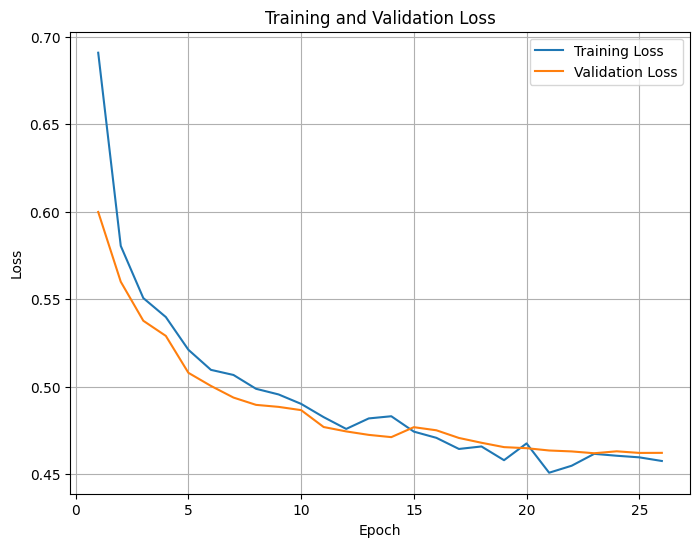

In [141]:
import matplotlib.pyplot as plt
# lossの変化を取得
train_loss = final.history['loss']
val_loss = final.history['val_loss']

# グラフのプロット
plt.figure(figsize=(8, 6))
plt.plot(range(1, len(train_loss) + 1), train_loss, label='Training Loss')
plt.plot(range(1, len(val_loss) + 1), val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [142]:
y_pred = model.predict(X_test)

print(y_pred)

# df_submit = pd.DataFrame(predictions,columns=['Survived'])#新たな提出用dfを定義
# df_submit.Survived = round(df_submit.Survived)
# df_submit

14/14 [==============================] - 0s 2ms/step
[[0.07671933]
 [0.44257402]
 [0.075147  ]
 [0.11166729]
 [0.32925946]
 [0.18391098]
 [0.7147679 ]
 [0.15738875]
 [0.6876269 ]
 [0.09837763]
 [0.13149823]
 [0.22479355]
 [0.9392218 ]
 [0.06834997]
 [0.94392383]
 [0.8876029 ]
 [0.10214307]
 [0.21233116]
 [0.37724727]
 [0.69233686]
 [0.33218336]
 [0.3662798 ]
 [0.94385713]
 [0.5217157 ]
 [0.928355  ]
 [0.05353743]
 [0.9483237 ]
 [0.19651398]
 [0.2344132 ]
 [0.14925541]
 [0.07487638]
 [0.12560287]
 [0.28844005]
 [0.33554786]
 [0.35602394]
 [0.24261199]
 [0.46296299]
 [0.46325532]
 [0.11833808]
 [0.16115525]
 [0.123955  ]
 [0.35950494]
 [0.07505937]
 [0.8739394 ]
 [0.94342256]
 [0.11754384]
 [0.27550116]
 [0.11205871]
 [0.94578433]
 [0.4137511 ]
 [0.33805913]
 [0.1975099 ]
 [0.7738566 ]
 [0.89838254]
 [0.27503318]
 [0.07123603]
 [0.08877049]
 [0.11740594]
 [0.12025485]
 [0.941836  ]
 [0.1529761 ]
 [0.11332487]
 [0.14437132]
 [0.7007    ]
 [0.5732348 ]
 [0.8766027 ]
 [0.6912051 ]
 [0.23638

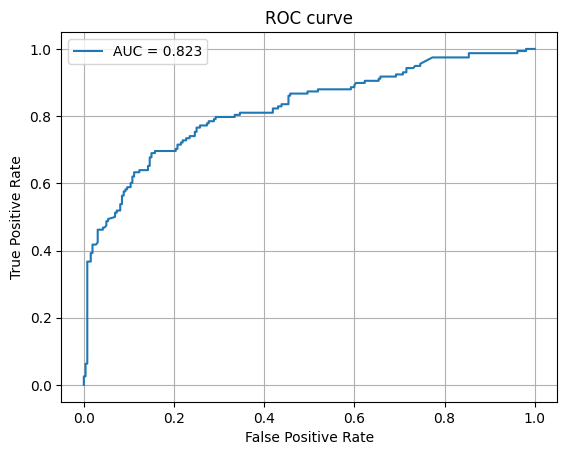

In [143]:
df_answer = pd.read_csv('./kaggle/input/titanic/answer.csv')

Y_test = df_answer['Survived']

Y_test.head()

from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred)
auc_score = roc_auc_score(Y_test, y_pred)
plt.plot(fpr, tpr, label='AUC = %.3f' % (auc_score))
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)


# accuracy: 0.8208955223880597
# f1_score: 0.7446808510638298
